# NBA Playoff Predictor - Data Cleaning

This notebook cleans and preprocesses NBA data from Kaggle to prepare it for feature engineering. It ensures standardized formats, handles missing values, and maintains data quality across sources.

## Data Sources and Cleaning Goals

1. **NBA/ABA/BAA Stats (sumitrodatta)**
   - **Player Season Info**: Individual player stats per season
     - Standardize team names
     - Filter for NBA-only data
     - Add conference information
     - Handle missing values
   - **Team Stats Per Game**: Team performance metrics
     - Normalize team names
     - Add conference mappings
     - Ensure consistent stats

2. **NBA Injury Stats (loganlauton)**
   - Historical injury data (1951-2023)
     - Remove data before 2024
     - Normalize team names
     - Remove missing values
     - Add conference mappings
     - Create yearly injury summaries by team


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path

sys.path.append('..')

from src.data.cleaners.nba_data_cleaner import NBACleaner
from src.data.utils import setup_logging

logger = setup_logging()

sns.set_theme()

cleaner = NBACleaner()

## Clean NBA/ABA/BAA Stats

Process data from sumitrodatta's dataset by standardizing formats, adding conference details, and removing anomalies to ensure accurate analysis.


# Player Season Data Cleaning Script

This script cleans and standardizes NBA player season data for analysis. It performs the following steps:

1. **Load Data**: Reads the raw player season data from a CSV file.
2. **Filter by Season**: Removes records from seasons before 2004 to focus on recent data.
3. **Drop Unnecessary Columns**: Removes irrelevant columns like `player_id`, `seas_id`, `birth_year`, `pos`, and `lg`.
4. **Standardize Names**:
   - Standardizes player names using `NBACleaner`
   - Converts team names to uppercase and standardizes them
5. **Add Conference Information**:
   - Maps teams to their respective conferences
   - No historical alignment handling since we only use data from 2004 onward
6. **Convert Columns**:
   - Converts the `age` column to an integer type
   - Standardizes other numeric columns as needed
7. **Validate Data**:
   - Checks for missing values
   - Verifies conference mappings

### Output
- A cleaned dataset saved as `../data/processed/player_season.csv`
- Includes player statistics with team and conference information


In [17]:
# Load and clean player season info data
logger.info("Loading player season info data...")
ps_df_raw = pd.read_csv('../data/raw/kaggle/sumitrodatta/nba-aba-baa-stats/Player Season Info.csv')
logger.info(f"Initial player season info records: {len(ps_df_raw):,}")

# Make a copy of the raw data for processing
ps_df_processed = ps_df_raw.copy()

# Filter out data before 2004
logger.info("Filtering out records before 2004...")
ps_df_processed = ps_df_processed[ps_df_processed['season'] >= 2004]
logger.info(f"Records after filtering pre-2004 data: {len(ps_df_processed):,}")

# Drop unnecessary columns
columns_to_drop = ['player_id', 'seas_id', 'birth_year', 'pos', 'lg']
logger.info(f"Dropping unnecessary columns: {columns_to_drop}...")
ps_df_processed.drop(columns=columns_to_drop, inplace=True)
logger.info("Unnecessary columns dropped.")

# Standardize player names
logger.info("Standardizing player names...")
ps_df_processed = cleaner.standardize_player_names(ps_df_processed)
logger.info("Player name standardization complete.")

# Standardize team names
logger.info("Standardizing team names: converting to uppercase and stripping whitespace...")
ps_df_processed['tm'] = ps_df_processed['tm'].str.strip().str.upper()
ps_df_processed = cleaner.standardize_team_names(ps_df_processed, ['tm'])
logger.info("Team name standardization complete.")

# Rename 'tm' column to 'team'
logger.info("Renaming 'tm' column to 'team'...")
ps_df_processed.rename(columns={'tm': 'team'}, inplace=True)
logger.info("Column 'tm' successfully renamed to 'team'.")

logger.info("Dropping rows where team equals 'TOT'...")
initial_rows = len(ps_df_processed)
ps_df_processed = ps_df_processed[ps_df_processed['team'] != 'TOT']
rows_dropped = initial_rows - len(ps_df_processed)
logger.info(f"Dropped {rows_dropped:,} rows with team 'TOT'")
logger.info(f"Remaining rows: {len(ps_df_processed):,}")

# Convert 'age' column to integer type
logger.info("Converting 'age' column to integer type...")
ps_df_processed['age'] = pd.to_numeric(ps_df_processed['age'], errors='coerce').fillna(0).astype(int)
logger.info("'age' column conversion to integer complete.")

# Add conference mappings
ps_df_processed = cleaner.add_conference_mappings(ps_df_processed, name_col='team')

unknown_teams = ps_df_processed[ps_df_processed['conference'] == 'Unknown']['team'].unique()
if len(unknown_teams) > 0:
    logger.warning(f"Found teams with unknown conference: {unknown_teams}")
else:
    logger.info("All teams successfully mapped to conferences")

logger.info("Dropping rows with unknown conferences...")
initial_rows = len(ps_df_processed)
ps_df_processed = ps_df_processed[ps_df_processed['conference'] != 'Unknown']
rows_dropped = initial_rows - len(ps_df_processed)
logger.info(f"Dropped {rows_dropped:,} rows with unknown conferences")
logger.info(f"Remaining rows: {len(ps_df_processed):,}")

# Check for NaN values
logger.info("Checking for NaN values in the dataset...")
nan_cols = ps_df_processed.columns[ps_df_processed.isna().any()].tolist()
if nan_cols:
    logger.warning(f"Found NaN values in the following columns: {nan_cols}")
    for col in nan_cols:
        nan_count = ps_df_processed[col].isna().sum()
        logger.warning(f"Column '{col}' has {nan_count:,} NaN values.")
else:
    logger.info("No NaN values found in the cleaned DataFrame.")

# Display sample and save
print("\nSample of cleaned data:")
print(ps_df_processed.head())

output_path = '../data/processed/player_season.csv'
ps_df_processed.to_csv(output_path, index=False)
logger.info(f"Cleaned data saved to {output_path}")

2024-12-11 21:28:18 - INFO - Loading player season info data...
2024-12-11 21:28:18 - INFO - Initial player season info records: 32,358
2024-12-11 21:28:18 - INFO - Filtering out records before 2004...
2024-12-11 21:28:18 - INFO - Records after filtering pre-2004 data: 13,629
2024-12-11 21:28:18 - INFO - Dropping unnecessary columns: ['player_id', 'seas_id', 'birth_year', 'pos', 'lg']...
2024-12-11 21:28:18 - INFO - Unnecessary columns dropped.
2024-12-11 21:28:18 - INFO - Standardizing player names...
2024-12-11 21:28:18 - INFO - Player name standardization complete.
2024-12-11 21:28:18 - INFO - Standardizing team names: converting to uppercase and stripping whitespace...
2024-12-11 21:28:18 - INFO - Team name standardization complete.
2024-12-11 21:28:18 - INFO - Renaming 'tm' column to 'team'...
2024-12-11 21:28:18 - INFO - Column 'tm' successfully renamed to 'team'.
2024-12-11 21:28:18 - INFO - Dropping rows where team equals 'TOT'...
2024-12-11 21:28:18 - INFO - Dropped 1,348 rows


Sample of cleaned data:
       season          player  age team  experience conference
18729    2004     Aaron McKie   31  PHI          10       EAST
18730    2004  Aaron Williams   32  BKN          10       EAST
18731    2004    Adonal Foyle   28  GSW           7       WEST
18732    2004  Adrian Griffin   29  HOU           5       WEST
18733    2004   Al Harrington   23  IND           6       EAST


This section visualizes the data cleaning process for the "Player Season Data" dataset, comparing the raw and processed data counts.

- **Dataset Name**: Player Season Data
- **Raw Data Count**: `raw_count`
- **Processed Data Count**: `processed_count`

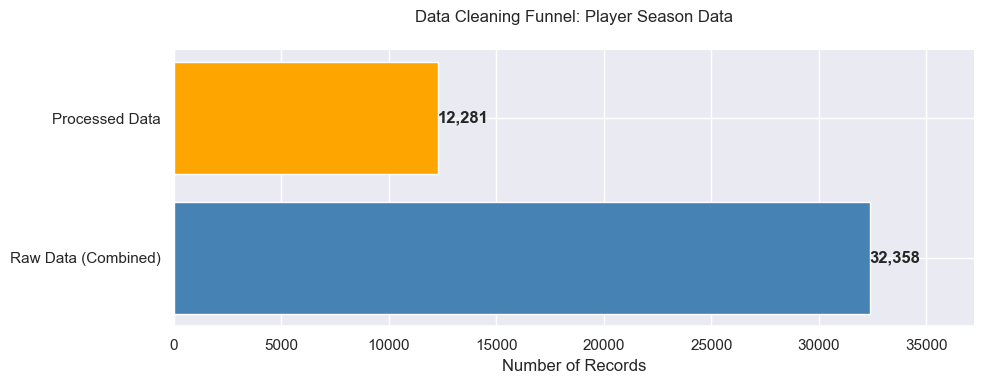

In [18]:
# Data for Player Season Data
dataset_name = "Player Season Data"
raw_count = len(ps_df_raw)  
processed_count = len(ps_df_processed) 

# Data for plotting
stages = ['Raw Data (Combined)', 'Processed Data']
counts = [raw_count, processed_count]
colors = ['steelblue', 'orange']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Create horizontal bars
bars = ax.barh(stages, counts, color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}',
            ha='left', va='center', fontweight='bold')

# Customize the chart
ax.set_title(f'Data Cleaning Funnel: {dataset_name}', pad=20)
ax.set_xlabel('Number of Records')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding
ax.set_xlim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# Team Statistics Data Cleaning Script

This script processes and cleans NBA team statistics data for analysis. It performs the following steps:

1. **Load Data**: Reads the raw team statistics data.
2. **Filter by Season**: Removes records prior to 2004.
3. **Remove League Averages**: Excludes league average entries.
4. **Standardize Team Names**:
   - Converts team names to uppercase
   - Maps team names to standardized codes
5. **Add Conference Information**:
   - Maps teams to their respective conferences
   - Validates conference assignments
6. **Convert Data Types**:
   - Handles numeric columns
   - Converts percentages to decimals
7. **Validate Data**:
   - Checks for missing values
   - Verifies data consistency

### Output
- A cleaned dataset saved as `../data/processed/team_stats.csv`
- Includes team statistics with conference information


In [19]:
# Load and clean team stats data
logger.info("Loading team stats data...")
ts_df_raw = pd.read_csv('../data/raw/kaggle/sumitrodatta/nba-aba-baa-stats/Team Stats Per Game.csv')
logger.info(f"Initial team stats records: {len(ts_df_raw):,}")

# Make a copy of the raw data for processing
ts_df_processed = ts_df_raw.copy()

# Filter out data before 2004
logger.info("Filtering out records before 2004...")
ts_df_processed = ts_df_processed[ts_df_processed['season'] >= 2004]
logger.info(f"Records after filtering pre-2004 data: {len(ts_df_processed):,}")

# Remove League Average entries
logger.info("Removing 'League Average' entries from the data...")
ts_df_processed = ts_df_processed[~ts_df_processed['team'].str.contains('League Average', case=False, na=False)]
logger.info(f"Records after removing 'League Average' entries: {len(ts_df_processed):,}")

# Standardize team names
logger.info("Standardizing team names...")
ts_df_processed['team'] = ts_df_processed['team'].str.strip().str.upper()
ts_df_processed = cleaner.standardize_team_names(ts_df_processed, ['team'])
logger.info("Team name standardization complete.")

# Convert percentage strings to decimals
logger.info("Converting percentage strings to decimal values...")
ts_df_processed = cleaner.convert_percentages(ts_df_processed)
logger.info("Percentage conversion complete.")

# Add conference mappings
ts_df_processed = cleaner.add_conference_mappings(ts_df_processed, name_col='team')

unknown_teams = ts_df_processed[ts_df_processed['conference'] == 'Unknown']['team'].unique()
if len(unknown_teams) > 0:
    logger.warning(f"Found teams with unknown conference: {unknown_teams}")
else:
    logger.info("All teams successfully mapped to conferences")

# Check for NaN values
logger.info("Checking for NaN values in the dataset...")
nan_cols = ts_df_processed.columns[ts_df_processed.isna().any()].tolist()
if nan_cols:
    logger.warning(f"Found NaN values in the following columns: {nan_cols}")
    for col in nan_cols:
        nan_count = ts_df_processed[col].isna().sum()
        logger.warning(f"Column '{col}' has {nan_count:,} NaN values.")
else:
    logger.info("No NaN values found in the cleaned DataFrame.")

# Display sample and save
print("\nSample of cleaned data:")
print(ts_df_processed.head())

output_path = '../data/processed/team_stats.csv'
ts_df_processed.to_csv(output_path, index=False)
logger.info(f"Cleaned data saved to {output_path}")

2024-12-11 21:28:18 - INFO - Loading team stats data...
2024-12-11 21:28:18 - INFO - Initial team stats records: 1,876
2024-12-11 21:28:18 - INFO - Filtering out records before 2004...
2024-12-11 21:28:18 - INFO - Records after filtering pre-2004 data: 681
2024-12-11 21:28:18 - INFO - Removing 'League Average' entries from the data...
2024-12-11 21:28:18 - INFO - Records after removing 'League Average' entries: 659
2024-12-11 21:28:18 - INFO - Standardizing team names...
2024-12-11 21:28:18 - INFO - Team name standardization complete.
2024-12-11 21:28:18 - INFO - Converting percentage strings to decimal values...
2024-12-11 21:28:18 - INFO - Percentage conversion complete.
2024-12-11 21:28:18 - INFO - All teams successfully mapped to conferences
2024-12-11 21:28:18 - INFO - Checking for NaN values in the dataset...
2024-12-11 21:28:18 - INFO - No NaN values found in the cleaned DataFrame.
2024-12-11 21:28:18 - INFO - Cleaned data saved to ../data/processed/team_stats.csv



Sample of cleaned data:
   season   lg team abbreviation  playoffs     g  mp_per_game  fg_per_game  \
0    2025  NBA  ATL          ATL     False  21.0        240.0         42.4   
1    2025  NBA  BOS          BOS     False  19.0        243.9         41.8   
2    2025  NBA  BKN          BRK     False  20.0        242.5         39.4   
3    2025  NBA  CHI          CHI     False  21.0        240.0         43.1   
4    2025  NBA  CHA          CHO     False  20.0        242.5         38.6   

   fga_per_game  fg_percent  ...  orb_per_game  drb_per_game  trb_per_game  \
0          91.5       0.463  ...          12.3          32.9          45.2   
1          90.3       0.464  ...          10.1          33.2          43.3   
2          84.0       0.468  ...           8.5          29.8          38.3   
3          90.8       0.475  ...           8.9          35.2          44.1   
4          91.0       0.424  ...          13.4          32.4          45.8   

   ast_per_game  stl_per_game  blk_pe

This section visualizes the data cleaning process for the "Team Statistics Data" dataset, comparing the raw and processed data counts.

- **Dataset Name**: Team Statistics Data
- **Raw Data Count**: `raw_count`
- **Processed Data Count**: `processed_count`

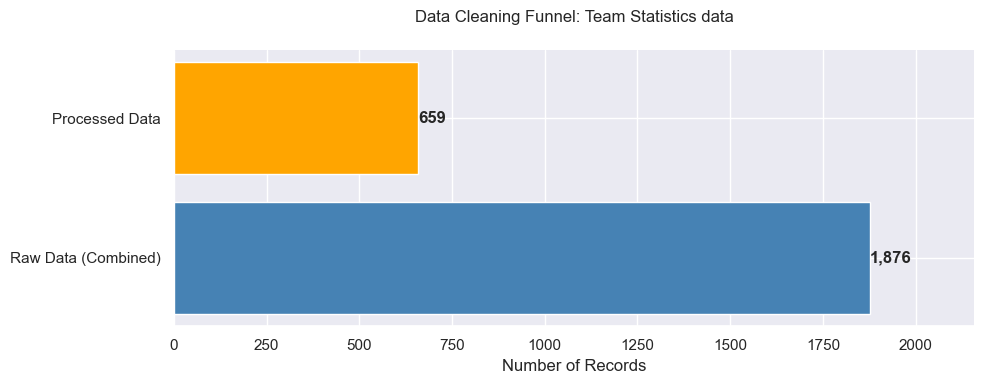

In [20]:
# Data for Team Statistics data
dataset_name = "Team Statistics data"
raw_count = len(ts_df_raw)
processed_count = len(ts_df_processed)

# Data for plotting
stages = ['Raw Data (Combined)', 'Processed Data']
counts = [raw_count, processed_count]
colors = ['steelblue', 'orange']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Create horizontal bars
bars = ax.barh(stages, counts, color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}',
            ha='left', va='center', fontweight='bold')

# Customize the chart
ax.set_title(f'Data Cleaning Funnel: {dataset_name}', pad=20)
ax.set_xlabel('Number of Records')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding
ax.set_xlim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# Injury Data Cleaning and Summary Script

This script processes NBA player injury data to generate team-level injury summaries. It performs the following steps:

1. **Load Data**: Reads raw injury data.
2. **Clean Dates**: Converts date columns to a consistent datetime format.
3. **Filter Data**: Removes records before 2004.
4. **Standardize Teams**:
   - Converts team names to a standardized format
   - Maps historical team names to current ones
5. **Add Conference Information**:
   - Maps teams to their respective conferences
   - Validates conference assignments
6. **Create Summary**:
   - Groups data by year and team
   - Counts injuries per team-season

### Outputs
- **Injury Summary**: A CSV file saved as `../data/processed/injuries_summary.csv`
  - Includes year, team, conference, and injury count


In [21]:
# Load and clean injury data
logger.info("Loading player injury data...")
injury_df_raw = pd.read_csv('../data/raw/kaggle/loganlauton/nba-injury-stats-1951-2023/NBA Player Injury Stats(1951 - 2023).csv')
logger.info(f"Initial player injury records: {len(injury_df_raw):,}")

# Make a copy of the raw data for processing
injury_df_processed = injury_df_raw.copy()

# Convert dates to datetime
logger.info("Converting 'Date' column to datetime format...")
injury_df_processed = cleaner.handle_dates(injury_df_processed, ['Date'])
logger.info("Date conversion complete.")

# Filter out data before 2004
logger.info("Filtering out records before 2004...")
injury_df_processed = injury_df_processed[injury_df_processed['Date'] >= '2004-01-01']
logger.info(f"Records after filtering pre-2004 data: {len(injury_df_processed):,}")

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Acquired', 'Relinquished', 'Notes']
logger.info(f"Dropping unnecessary columns: {columns_to_drop}...")
injury_df_processed.drop(columns=columns_to_drop, inplace=True)
logger.info("Unnecessary columns dropped.")

# Standardize team names
logger.info("Standardizing team names...")
injury_df_processed['Team'] = injury_df_processed['Team'].str.strip().str.upper()
injury_df_processed = cleaner.standardize_team_names(injury_df_processed, ['Team'])
logger.info("Team name standardization complete.")

# Extract year and create summary
logger.info("Creating injury summary...")
injury_df_processed['Year'] = injury_df_processed['Date'].dt.year
injury_summary_df = injury_df_processed.groupby(['Year', 'Team']).size().reset_index(name='Count')

# Add conference mappings
injury_summary_df = cleaner.add_conference_mappings(injury_summary_df, name_col='Team')

unknown_teams = injury_summary_df[injury_summary_df['conference'] == 'Unknown']['Team'].unique()
if len(unknown_teams) > 0:
    logger.warning(f"Found teams with unknown conference: {unknown_teams}")
else:
    logger.info("All teams successfully mapped to conferences")

# Standardize column names
logger.info("Converting column names to lowercase...")
injury_summary_df.columns = injury_summary_df.columns.str.lower()

# Display sample and save
print("\nSample of injury summary:")
print(injury_summary_df.head())

output_path = '../data/processed/injuries_summary.csv'
injury_summary_df.to_csv(output_path, index=False)
logger.info(f"Injury summary saved to {output_path}")

2024-12-11 21:28:18 - INFO - Loading player injury data...
2024-12-11 21:28:19 - INFO - Initial player injury records: 37,667
2024-12-11 21:28:19 - INFO - Converting 'Date' column to datetime format...
2024-12-11 21:28:19 - INFO - Date conversion complete.
2024-12-11 21:28:19 - INFO - Filtering out records before 2004...
2024-12-11 21:28:19 - INFO - Records after filtering pre-2004 data: 31,385
2024-12-11 21:28:19 - INFO - Dropping unnecessary columns: ['Unnamed: 0', 'Acquired', 'Relinquished', 'Notes']...
2024-12-11 21:28:19 - INFO - Unnecessary columns dropped.
2024-12-11 21:28:19 - INFO - Standardizing team names...
2024-12-11 21:28:19 - INFO - Team name standardization complete.
2024-12-11 21:28:19 - INFO - Creating injury summary...
2024-12-11 21:28:19 - INFO - All teams successfully mapped to conferences
2024-12-11 21:28:19 - INFO - Converting column names to lowercase...
2024-12-11 21:28:19 - INFO - Injury summary saved to ../data/processed/injuries_summary.csv



Sample of injury summary:
   year team  count conference
0  2004  ATL     20       EAST
1  2004  BKN     21       EAST
2  2004  BOS     16       EAST
3  2004  CHA     36       EAST
4  2004  CHI     25       EAST


# Data for Player Injury Data

This section visualizes the data cleaning process for the "Player Injury Data" dataset, comparing the raw and processed data counts.

- **Dataset Name**: Player Injury Data
- **Raw Data Count**: `raw_count`
- **Processed Data Count**: `processed_count`

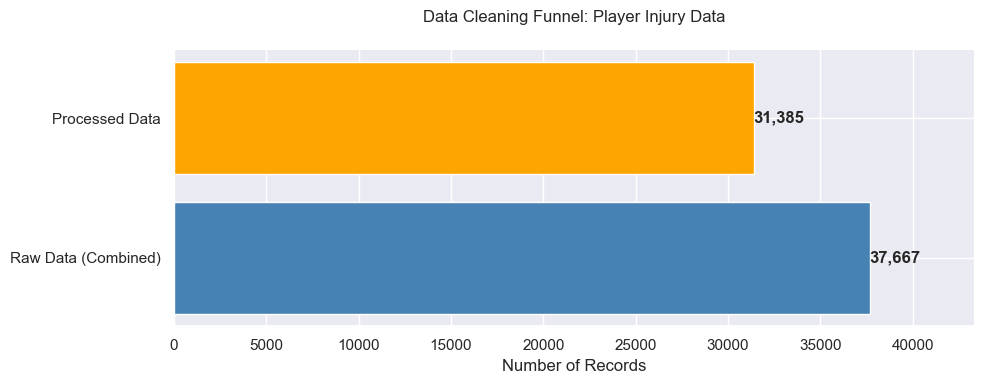

In [22]:
# Data for Player Injury Data
dataset_name = "Player Injury Data"
raw_count = len(injury_df_raw)  
processed_count = len(injury_df_processed) 

# Data for plotting
stages = ['Raw Data (Combined)', 'Processed Data']
counts = [raw_count, processed_count]
colors = ['steelblue', 'orange']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Create horizontal bars
bars = ax.barh(stages, counts, color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}',
            ha='left', va='center', fontweight='bold')

# Customize the chart
ax.set_title(f'Data Cleaning Funnel: {dataset_name}', pad=20)
ax.set_xlabel('Number of Records')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding
ax.set_xlim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# Conclusions

This section summarizes the key findings and outcomes of the data cleaning process.

- **Data Cleaning Success**: The raw data from multiple sources has been successfully cleaned, standardized, and processed, ensuring consistency and accuracy for further analysis.
- **Data Quality Improvement**: Missing values have been addressed, team names standardized, and conference mappings added to all datasets.
- **Summary of Key Metrics**:
  - The number of records in the raw data has been reduced as we focused on relevant data (post-2004) and removed unnecessary columns.
  - Data from multiple sources, including player season statistics, team stats, and injury data, is now consistent and ready for feature engineering and analysis.
- **Next Steps**: 
  - The cleaned datasets will be used for feature engineering and training the NBA Playoff Predictor model.
  - Further analysis will focus on identifying key predictors for playoff success, using the processed player and team statistics, along with injury data summaries.